In [1]:
import math

In [2]:
# Fix the seed to get reproductible results
import numpy as np
np.random.seed(123)

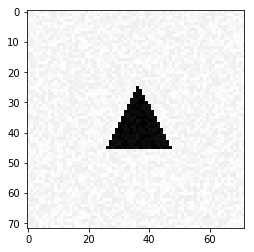

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]




In [4]:
label_mapping = {
    0: 'rectangle',
    1: 'disk',
    2: 'triangle'
}

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils

Using TensorFlow backend.


In [6]:
nb_epochs = 20
batch_size = 32

### 3 Simple Classification

In [7]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = np_utils.to_categorical(Y_train, 3) 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


###### Train linear classifier with SGD optimizer

In [8]:
model = Sequential([
    Dense(3, activation='softmax',input_shape=X_train[0].shape)
])
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epochs)

Epoch 1/20
300/300 [==============================] - 0s 1ms/step - loss: 5.8463 - acc: 0.4100
Epoch 2/20
300/300 [==============================] - 0s 200us/step - loss: 7.4746 - acc: 0.3667
Epoch 3/20
300/300 [==============================] - 0s 223us/step - loss: 8.6359 - acc: 0.3400
Epoch 4/20
300/300 [==============================] - 0s 193us/step - loss: 7.2648 - acc: 0.3967
Epoch 5/20
300/300 [==============================] - 0s 136us/step - loss: 8.5078 - acc: 0.3667
Epoch 6/20
300/300 [==============================] - 0s 209us/step - loss: 7.8425 - acc: 0.3800
Epoch 7/20
300/300 [==============================] - 0s 120us/step - loss: 7.6816 - acc: 0.4000
Epoch 8/20
300/300 [==============================] - 0s 130us/step - loss: 7.3506 - acc: 0.3767
Epoch 9/20
300/300 [==============================] - 0s 119us/step - loss: 7.5984 - acc: 0.4133
Epoch 10/20
300/300 [==============================] - 0s 123us/step - loss: 7.0060 - acc: 0.4767
Epoch 11/20
300/300 [==========

###### Train linear classifier with Adam optimizer

In [9]:
model = Sequential([
    Dense(3, activation='softmax',input_shape=X_train[0].shape)
])
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epochs)

Epoch 1/20
300/300 [==============================] - 0s 1ms/step - loss: 1.5324 - acc: 0.4000
Epoch 2/20
300/300 [==============================] - 0s 146us/step - loss: 0.8778 - acc: 0.5700
Epoch 3/20
300/300 [==============================] - 0s 160us/step - loss: 0.5251 - acc: 0.7933
Epoch 4/20
300/300 [==============================] - 0s 160us/step - loss: 0.4554 - acc: 0.8167
Epoch 5/20
300/300 [==============================] - 0s 160us/step - loss: 0.3351 - acc: 0.9233
Epoch 6/20
300/300 [==============================] - 0s 130us/step - loss: 0.2950 - acc: 0.9167
Epoch 7/20
300/300 [==============================] - 0s 126us/step - loss: 0.2442 - acc: 0.9467
Epoch 8/20
300/300 [==============================] - 0s 133us/step - loss: 0.2086 - acc: 0.9867
Epoch 9/20
300/300 [==============================] - 0s 133us/step - loss: 0.2186 - acc: 0.9333
Epoch 10/20
300/300 [==============================] - 0s 136us/step - loss: 0.2056 - acc: 0.9167
Epoch 11/20
300/300 [==========

We can notice two things:
    - Sgd converged slowly compared to Adam
    - Sgd seems to be more sensitive to weights initialisation for a linear classifier because sometimes it does not converge at all whereas we always had a convergence for Adam

### 4 Visualization of the Solution

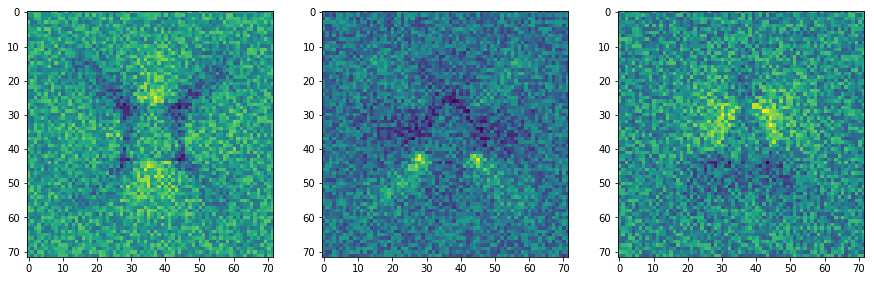

In [ ]:
f = plt.figure(figsize=(15, 15))
axarr = f.subplots(1,3)
for i in range(3):
    axarr[i].imshow(model.get_weights()[0][:,i].reshape((IMAGE_SIZE,IMAGE_SIZE)))

We can see that they look like shapes detector

### 5 A More Difficult Classification Problem

In [ ]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [ ]:
[X_train, Y_train] = generate_dataset_classification(3000, 20, True)
Y_train = np_utils.to_categorical(Y_train, 3) 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

###### Linear model with 300 samples

In [ ]:
model = Sequential([
    Dense(3, activation='softmax',input_shape=X_train[0].shape)
])
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train[:300], Y_train[:300], batch_size=batch_size, epochs=nb_epochs)

Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 1.6701 - acc: 0.3900
Epoch 2/20
300/300 [==============================] - 0s 339us/step - loss: 1.1869 - acc: 0.4167
Epoch 3/20
300/300 [==============================] - 0s 143us/step - loss: 1.2100 - acc: 0.4600
Epoch 4/20
300/300 [==============================] - 0s 193us/step - loss: 1.0467 - acc: 0.4333
Epoch 5/20
300/300 [==============================] - 0s 143us/step - loss: 0.9308 - acc: 0.5133
Epoch 6/20
300/300 [==============================] - 0s 169us/step - loss: 0.9348 - acc: 0.5400
Epoch 7/20
300/300 [==============================] - 0s 166us/step - loss: 0.9220 - acc: 0.5300
Epoch 8/20
300/300 [==============================] - 0s 123us/step - loss: 0.8414 - acc: 0.5900
Epoch 9/20
300/300 [==============================] - 0s 179us/step - loss: 0.8711 - acc: 0.5700
Epoch 10/20
300/300 [==============================] - 0s 126us/step - loss: 0.8757 - acc: 0.5933
Epoch 11/20
300/300 [==========

In [ ]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 299us/step


[0.9748693895339966, 0.5233333333333333]

###### Linear model with 3000 samples

In [ ]:
model = Sequential([
    Dense(3, activation='softmax',input_shape=X_train[0].shape)
])
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epochs)

Epoch 1/20
3000/3000 [==============================] - 1s 295us/step - loss: 1.3415 - acc: 0.4437
Epoch 2/20
3000/3000 [==============================] - 1s 170us/step - loss: 0.9592 - acc: 0.5453
Epoch 3/20
3000/3000 [==============================] - 0s 164us/step - loss: 0.9279 - acc: 0.5700
Epoch 4/20
3000/3000 [==============================] - 0s 151us/step - loss: 0.8666 - acc: 0.5720
Epoch 5/20
3000/3000 [==============================] - 0s 156us/step - loss: 0.8653 - acc: 0.5750
Epoch 6/20
3000/3000 [==============================] - 0s 149us/step - loss: 0.8468 - acc: 0.5960
Epoch 7/20
3000/3000 [==============================] - 0s 157us/step - loss: 0.9674 - acc: 0.5460
Epoch 8/20
3000/3000 [==============================] - 0s 143us/step - loss: 0.8377 - acc: 0.5893
Epoch 9/20
3000/3000 [==============================] - 0s 140us/step - loss: 0.8890 - acc: 0.5990
Epoch 10/20
3000/3000 [==============================] - 0s 146us/step - loss: 0.8461 - acc: 0.6007
Epoch 11/

In [ ]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 445us/step


[0.9709965753555297, 0.526666667064031]

###### convolutional network with 300 samples

In [ ]:
model = Sequential()
model.add(Conv2D(16, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1)[:300], Y_train[:300],
          batch_size=batch_size, epochs=nb_epochs, verbose=1)

Epoch 1/20
300/300 [==============================] - 2s 6ms/step - loss: 1.2850 - acc: 0.3633
Epoch 2/20
300/300 [==============================] - 1s 5ms/step - loss: 1.0176 - acc: 0.4867
Epoch 3/20
300/300 [==============================] - 1s 5ms/step - loss: 0.8317 - acc: 0.7233
Epoch 4/20
300/300 [==============================] - 1s 5ms/step - loss: 0.7208 - acc: 0.7800
Epoch 5/20
300/300 [==============================] - 1s 5ms/step - loss: 0.6461 - acc: 0.7833
Epoch 6/20
300/300 [==============================] - 1s 5ms/step - loss: 0.5757 - acc: 0.8300
Epoch 7/20
300/300 [==============================] - 1s 4ms/step - loss: 0.5202 - acc: 0.8500
Epoch 8/20
300/300 [==============================] - 1s 5ms/step - loss: 0.4733 - acc: 0.8600
Epoch 9/20
300/300 [==============================] - 1s 4ms/step - loss: 0.4568 - acc: 0.8467
Epoch 10/20
300/300 [==============================] - 1s 4ms/step - loss: 0.4099 - acc: 0.8767
Epoch 11/20
300/300 [============================

In [ ]:
model.evaluate(X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), Y_test)

300/300 [==============================] - 1s 2ms/step


[0.6957008179028829, 0.7066666666666667]

###### convolutional network with 3000 samples

In [ ]:
model = Sequential()
model.add(Conv2D(16, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1), Y_train,
          batch_size=batch_size, epochs=nb_epochs, verbose=1)

Epoch 1/20
3000/3000 [==============================] - 15s 5ms/step - loss: 0.8934 - acc: 0.6190
Epoch 2/20
3000/3000 [==============================] - 14s 5ms/step - loss: 0.5706 - acc: 0.7947
Epoch 3/20
3000/3000 [==============================] - 15s 5ms/step - loss: 0.4624 - acc: 0.8520
Epoch 4/20
3000/3000 [==============================] - 15s 5ms/step - loss: 0.3900 - acc: 0.8750
Epoch 5/20
3000/3000 [==============================] - 15s 5ms/step - loss: 0.3154 - acc: 0.9033
Epoch 6/20
3000/3000 [==============================] - 14s 5ms/step - loss: 0.2579 - acc: 0.9337
Epoch 7/20
3000/3000 [==============================] - 15s 5ms/step - loss: 0.2105 - acc: 0.9497
Epoch 8/20
3000/3000 [==============================] - 15s 5ms/step - loss: 0.1751 - acc: 0.9543
Epoch 9/20
2176/3000 [====================>.........] - ETA: 4s - loss: 0.1564 - acc: 0.9623

In [ ]:
model.evaluate(X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), Y_test)

In [ ]:
model = Sequential()
model.add(Conv2D(16, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1), Y_train,
          batch_size=batch_size, epochs=nb_epochs, verbose=1)
model.evaluate(X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), Y_test)

**Acuracy**


|Model                 | 300 inputs | 3000 inputs |
|----------------------|------------|-------------|
|Linear Classifier     |0.53        |0.53         |
|Convolutional Network |0.7         |0.95         |

###### Inputs with a bad prediction for the convolutionnal network

In [ ]:
predictions = model.predict(X_test.reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1))

bad_predictions = np.argmax(d , axis=1) != np.argmax(Y_test, axis=1)

X_bad_predicted = X_test[bad_prediction]
Y_bad_predicted = Y_test[bad_prediction]

n_bad_prediction = X_bad_predicted.shape[0]

fig = plt.figure(figsize=(25,20))
axarr = fig.subplots(math.ceil(n_bad_prediction / 3),3)
for i in range(n_bad_prediction):
    axarr[i//3][i%3].imshow(X_bad_predicted[i].reshape(IMAGE_SIZE,IMAGE_SIZE))
    axarr[i//3][i%3].set_title(
        f'Label: {label_mapping[np.argmax(Y_bad_predicted[i])]}| Predicted: {label_mapping[np.argmax(d[bad_prediction][i])]}')

### 6 A Regression Problem

In [ ]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

In [ ]:
visualize_prediction(X_train[0], Y_train[0])

In [ ]:
def sort_points(x):
    return np.apply_along_axis(lambda x :sorted(list(x.reshape((3,2))), key= lambda y: (y[0], y[1])), axis=1, arr=x)

In [ ]:
def extract_relative_positions(x):
    def extract_positions(row):
        points = np.array(sorted(list(row.reshape((3,2))), key= lambda y: (y[0], y[1])), dtype='float')
        points = points - points[0, :]
        return points[1:]
    return np.apply_along_axis(extract_positions, axis=1, arr=x)

In [ ]:
def extract_smallest_point(x):
    fct = lambda x: min(list(x.reshape((3,2))), key= lambda y: (y[0], y[1])) 
    return np.apply_along_axis(fct, axis=1, arr=x)

In [ ]:
def points_from_relative_positions(Y_train, relative_positions):
    relative_positions = extract_relative_positions(Y_train)
    smallest_point = extract_smallest_point(Y_train)
    return np.concatenate([
        smallest_point.reshape((-1,1,2)),
        np.repeat(smallest_point.reshape((-1,2)), 2, axis=0).reshape((-1, 2,2)) + relative_positions],
        axis=1
    )

In [ ]:
sort_points(Y_train)

In [ ]:
transformed_train = extract_relative_positions(Y_train).reshape((-1,4))

In [ ]:
visualize_prediction(X_train[1], Y_train[1])

In [ ]:
X_test, Y_test = generate_test_set_regression()

In [ ]:
model = Sequential()
model.add(Conv2D(64, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(6))
model.compile(optimizer='Adam', loss='mean_squared_error')

model.fit(X_train.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1), sort_points(Y_train).reshape((-1,6)), epochs=20, batch_size=32)

model.evaluate(X_test.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1), sort_points(Y_test).reshape((-1,6)))

In [ ]:
def convert_to_cell_number(positions):
    x_cells = np.floor(positions.reshape((-1, 3,2))*72)[:,:,0]
    y_cells = np.floor(positions.reshape((-1, 3,2))*IMAGE_SIZE)[:,:,1] * IMAGE_SIZE
    cells = x_cells + y_cells
    cells = np_utils.to_categorical(cells, IMAGE_SIZE*IMAGE_SIZE)
    return cells[:,0,:] + cells[:,1,:] + cells[:,2,:]
    
def get_points_too_close(cells):
    invalid_indexes = np.unique(np.argwhere(cells > 1)[:,0])
    valid_indexes = set(i for i in range(cells.shape[0])) - set(invalid_indexes)
    return np.array(list(valid_indexes))

def convert_to_positions(cells):
    def _convert_to_positions(x):
        return [(x % IMAGE_SIZE)/IMAGE_SIZE, (x//IMAGE_SIZE)/IMAGE_SIZE]  
    return np.apply_along_axis(lambda x: _convert_to_positions(x[1]), axis= 1, arr=np.argwhere(cells == 1)).reshape((-1,6))



In [ ]:
Y_train_converted = convert_to_cell_number(Y_train)

In [ ]:
valid_indexes = get_points_too_close(Y_train_converted)

In [ ]:
X_train_filtered = X_train[valid_indexes]

In [ ]:
Y_train_converted_filtered = Y_train_converted[valid_indexes]

In [ ]:
visualize_prediction(X_train_filtered[8], convert_to_positions(Y_train_converted_filtered)[8])

In [ ]:
Y_train_converted_filtered.shape

In [ ]:
model = Sequential()
model.add(Conv2D(16, (5,5), input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(IMAGE_SIZE * IMAGE_SIZE, activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_filtered.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1), Y_train_converted_filtered, epochs=20, batch_size=32)



In [ ]:
model.evaluate(X_test.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1), sort_points(Y_test).reshape((-1,6)))

In [ ]:
Y_predicted_cells = model.predict(X_test.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1))



In [ ]:
visualize_prediction(Y_predicted_cells[2], Y_test[2])

In [ ]:
plt.imshow(Y_predicted_cells[0].reshape((IMAGE_SIZE, IMAGE_SIZE)))

In [ ]:
sorted(list(Y_predicted_cells[0]), reverse=True)

In [ ]:
Y_test[0]

In [ ]:
Y_predicted = convert_to_positions(Y_predicted_cells)

In [ ]:
nb_images=10
for i in range(nb_images):
    visualize_prediction(X_test[i], Y_predicted[i])


In [ ]:
# Best 0.023 
model = Sequential()
model.add(Conv2D(16, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(6))
model.compile(optimizer='Adam', loss='mean_squared_error')

model.fit(X_train.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1), sort_points(Y_train).reshape((-1,6)), epochs=20, batch_size=32)

In [ ]:
Y_predicted = model.predict(X_test.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1))



In [ ]:
nb_images=10
for i in range(nb_images):
    visualize_prediction(X_train[i], Y_train[i])


In [ ]:
model = Sequential()
model.add(Flatten())
model.add(Dense(1000, input_shape=(IMAGE_SIZE, IMAGE_SIZE,1), activation='softmax'))
model.add(Dense(6))
model.compile(optimizer='Adam', loss='mean_squared_error')



In [ ]:
model.fit(X_train.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1), sort_points(Y_train).reshape((-1,6)), epochs=20, batch_size=32)